In [1]:
from kuramoto.nmf import *

In [2]:
sampling_alg = 'pivot'

ntwk = 'Wisconsin87' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 23842
num edges in G 1671904


num of subgraphs induced on k-paths: 2500
X.shape (2500, 2500)


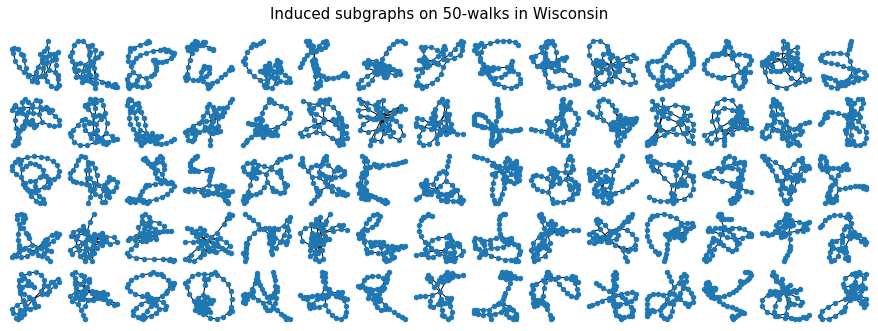

In [3]:
X, embs = G.get_patches(k=k, sample_size=2500, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [4]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 2500


In [5]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 3.5

for G in graph_list:
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2496,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2497,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2498,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False


In [6]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.0516


In [7]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

In [8]:
W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  3%|█                                 | 30/1000 [00:00<00:06, 151.07it/s]

iteration 0, reconstruction error 21517.829330
iteration 10, reconstruction error 9003.578944
iteration 20, reconstruction error 9222.824763
iteration 30, reconstruction error 9433.786409


  7%|██▍                               | 71/1000 [00:00<00:05, 177.80it/s]

iteration 40, reconstruction error 8992.401371
iteration 50, reconstruction error 8081.459272
iteration 60, reconstruction error 7676.149295
iteration 70, reconstruction error 7464.155389
iteration 80, reconstruction error 7289.122547


 11%|███▋                             | 113/1000 [00:00<00:04, 189.17it/s]

iteration 90, reconstruction error 7148.893189
iteration 100, reconstruction error 7040.630191
iteration 110, reconstruction error 6958.052958
iteration 120, reconstruction error 6893.200624
iteration 130, reconstruction error 6840.512051


 18%|█████▉                           | 181/1000 [00:00<00:03, 210.52it/s]

iteration 140, reconstruction error 6796.920448
iteration 150, reconstruction error 6760.616319
iteration 160, reconstruction error 6730.516733
iteration 170, reconstruction error 6705.437757
iteration 180, reconstruction error 6684.280712


 22%|███████▍                         | 224/1000 [00:01<00:03, 199.00it/s]

iteration 190, reconstruction error 6666.207207
iteration 200, reconstruction error 6650.643675
iteration 210, reconstruction error 6636.935120
iteration 220, reconstruction error 6624.855274


 26%|████████▋                        | 265/1000 [00:01<00:03, 193.21it/s]

iteration 230, reconstruction error 6614.130964
iteration 240, reconstruction error 6604.616096
iteration 250, reconstruction error 6596.146599
iteration 260, reconstruction error 6588.560772


 31%|██████████                       | 306/1000 [00:01<00:03, 193.06it/s]

iteration 270, reconstruction error 6581.699670
iteration 280, reconstruction error 6575.486475
iteration 290, reconstruction error 6569.788863
iteration 300, reconstruction error 6564.526709


 35%|███████████▍                     | 346/1000 [00:01<00:03, 188.70it/s]

iteration 310, reconstruction error 6559.654406
iteration 320, reconstruction error 6555.077380
iteration 330, reconstruction error 6550.793045
iteration 340, reconstruction error 6546.773105


 38%|████████████▋                    | 385/1000 [00:02<00:03, 188.69it/s]

iteration 350, reconstruction error 6542.962375
iteration 360, reconstruction error 6539.346194
iteration 370, reconstruction error 6535.908190
iteration 380, reconstruction error 6532.624059


 43%|██████████████                   | 426/1000 [00:02<00:03, 190.92it/s]

iteration 390, reconstruction error 6529.501902
iteration 400, reconstruction error 6526.515071
iteration 410, reconstruction error 6523.652159
iteration 420, reconstruction error 6520.914636


 47%|███████████████▌                 | 470/1000 [00:02<00:02, 205.04it/s]

iteration 430, reconstruction error 6518.286189
iteration 440, reconstruction error 6515.766802
iteration 450, reconstruction error 6513.335315
iteration 460, reconstruction error 6510.983570
iteration 470, reconstruction error 6508.707064


 51%|████████████████▉                | 513/1000 [00:02<00:02, 209.65it/s]

iteration 480, reconstruction error 6506.497286
iteration 490, reconstruction error 6504.350790
iteration 500, reconstruction error 6502.272710
iteration 510, reconstruction error 6500.264664
iteration 520, reconstruction error 6498.315797


 56%|██████████████████▍              | 558/1000 [00:02<00:02, 206.57it/s]

iteration 530, reconstruction error 6496.423708
iteration 540, reconstruction error 6494.600956
iteration 550, reconstruction error 6492.833572
iteration 560, reconstruction error 6491.116828
iteration 570, reconstruction error 6489.449769


 62%|████████████████████▌            | 624/1000 [00:03<00:01, 214.06it/s]

iteration 580, reconstruction error 6487.833211
iteration 590, reconstruction error 6486.263987
iteration 600, reconstruction error 6484.741876
iteration 610, reconstruction error 6483.259290
iteration 620, reconstruction error 6481.811986


 67%|██████████████████████           | 669/1000 [00:03<00:01, 217.87it/s]

iteration 630, reconstruction error 6480.395436
iteration 640, reconstruction error 6479.006836
iteration 650, reconstruction error 6477.659609
iteration 660, reconstruction error 6476.354046
iteration 670, reconstruction error 6475.088915


 71%|███████████████████████▌         | 713/1000 [00:03<00:01, 214.17it/s]

iteration 680, reconstruction error 6473.888913
iteration 690, reconstruction error 6472.720509
iteration 700, reconstruction error 6471.575337
iteration 710, reconstruction error 6470.452567
iteration 720, reconstruction error 6469.352270


 76%|█████████████████████████        | 759/1000 [00:03<00:01, 218.35it/s]

iteration 730, reconstruction error 6468.272360
iteration 740, reconstruction error 6467.210880
iteration 750, reconstruction error 6466.167533
iteration 760, reconstruction error 6465.162567
iteration 770, reconstruction error 6464.187261


 80%|██████████████████████████▌      | 805/1000 [00:04<00:00, 222.16it/s]

iteration 780, reconstruction error 6463.236787
iteration 790, reconstruction error 6462.312823
iteration 800, reconstruction error 6461.410869
iteration 810, reconstruction error 6460.531372
iteration 820, reconstruction error 6459.681318


 88%|████████████████████████████▉    | 877/1000 [00:04<00:00, 231.83it/s]

iteration 830, reconstruction error 6458.858588
iteration 840, reconstruction error 6458.062943
iteration 850, reconstruction error 6457.297296
iteration 860, reconstruction error 6456.556664
iteration 870, reconstruction error 6455.846563


 92%|██████████████████████████████▍  | 924/1000 [00:04<00:00, 225.86it/s]

iteration 880, reconstruction error 6455.168276
iteration 890, reconstruction error 6454.516724
iteration 900, reconstruction error 6453.888941
iteration 910, reconstruction error 6453.283186
iteration 920, reconstruction error 6452.707218


 97%|████████████████████████████████ | 970/1000 [00:04<00:00, 223.90it/s]

iteration 930, reconstruction error 6452.156695
iteration 940, reconstruction error 6451.631845
iteration 950, reconstruction error 6451.127132
iteration 960, reconstruction error 6450.641382
iteration 970, reconstruction error 6450.173169


100%|████████████████████████████████| 1000/1000 [00:04<00:00, 204.19it/s]


iteration 980, reconstruction error 6449.721462
iteration 990, reconstruction error 6449.285874


###########################
Shape of W_true: (2500, 16)
###########################




  0%|                                    | 2/1000 [00:00<00:56, 17.77it/s]

iteration 0, reconstruction error 358499.700832


  1%|▍                                  | 14/1000 [00:00<00:41, 23.50it/s]

iteration 10, reconstruction error 130675.987609


  3%|▉                                  | 26/1000 [00:01<00:40, 24.07it/s]

iteration 20, reconstruction error 136200.213890


  4%|█▏                                 | 35/1000 [00:01<00:40, 23.98it/s]

iteration 30, reconstruction error 144519.176714


  4%|█▌                                 | 44/1000 [00:01<00:39, 23.94it/s]

iteration 40, reconstruction error 145227.397962


  6%|█▉                                 | 56/1000 [00:02<00:39, 23.74it/s]

iteration 50, reconstruction error 145172.005598


  6%|██▎                                | 65/1000 [00:02<00:39, 23.74it/s]

iteration 60, reconstruction error 144973.319944


  7%|██▌                                | 74/1000 [00:03<00:38, 24.07it/s]

iteration 70, reconstruction error 144501.643547


  8%|██▉                                | 83/1000 [00:03<00:41, 21.94it/s]

iteration 80, reconstruction error 143436.478252


 10%|███▎                               | 95/1000 [00:04<00:40, 22.55it/s]

iteration 90, reconstruction error 141135.086042


 10%|███▌                              | 104/1000 [00:04<00:38, 23.09it/s]

iteration 100, reconstruction error 136463.124236


 11%|███▊                              | 113/1000 [00:04<00:40, 21.68it/s]

iteration 110, reconstruction error 128198.908002


 12%|████▎                             | 125/1000 [00:05<00:41, 21.31it/s]

iteration 120, reconstruction error 118275.288919


 13%|████▌                             | 134/1000 [00:05<00:42, 20.34it/s]

iteration 130, reconstruction error 113971.200846


 14%|████▊                             | 143/1000 [00:06<00:37, 22.56it/s]

iteration 140, reconstruction error 112442.303444


 16%|█████▎                            | 155/1000 [00:06<00:38, 21.87it/s]

iteration 150, reconstruction error 111228.516602


 16%|█████▌                            | 164/1000 [00:07<00:36, 23.18it/s]

iteration 160, reconstruction error 110222.204487


 18%|█████▉                            | 176/1000 [00:07<00:34, 23.60it/s]

iteration 170, reconstruction error 109403.222253


 18%|██████▎                           | 185/1000 [00:08<00:37, 21.81it/s]

iteration 180, reconstruction error 108746.028579


 19%|██████▌                           | 194/1000 [00:08<00:34, 23.31it/s]

iteration 190, reconstruction error 108218.356005


 21%|███████                           | 206/1000 [00:09<00:33, 23.78it/s]

iteration 200, reconstruction error 107794.861595


 22%|███████▎                          | 215/1000 [00:09<00:32, 23.84it/s]

iteration 210, reconstruction error 107451.333185


 22%|███████▌                          | 224/1000 [00:09<00:33, 22.97it/s]

iteration 220, reconstruction error 107170.183252


 24%|████████                          | 236/1000 [00:10<00:32, 23.73it/s]

iteration 230, reconstruction error 106938.200027


 24%|████████▎                         | 245/1000 [00:10<00:37, 20.08it/s]

iteration 240, reconstruction error 106745.078706


 25%|████████▋                         | 254/1000 [00:11<00:33, 22.51it/s]

iteration 250, reconstruction error 106581.624302


 26%|████████▉                         | 263/1000 [00:11<00:32, 22.66it/s]

iteration 260, reconstruction error 106441.336257


 28%|█████████▎                        | 275/1000 [00:12<00:32, 22.34it/s]

iteration 270, reconstruction error 106319.992191


 28%|█████████▋                        | 284/1000 [00:12<00:32, 21.96it/s]

iteration 280, reconstruction error 106214.279453


 29%|█████████▉                        | 293/1000 [00:12<00:31, 22.71it/s]

iteration 290, reconstruction error 106121.830393


 30%|██████████▎                       | 305/1000 [00:13<00:28, 24.00it/s]

iteration 300, reconstruction error 106040.750505


 31%|██████████▋                       | 314/1000 [00:13<00:28, 23.85it/s]

iteration 310, reconstruction error 105969.457860


 33%|███████████                       | 326/1000 [00:14<00:28, 24.05it/s]

iteration 320, reconstruction error 105906.733906


 34%|███████████▍                      | 335/1000 [00:14<00:27, 24.27it/s]

iteration 330, reconstruction error 105851.334773


 34%|███████████▋                      | 344/1000 [00:15<00:28, 23.15it/s]

iteration 340, reconstruction error 105802.394081


 35%|████████████                      | 353/1000 [00:15<00:27, 23.26it/s]

iteration 350, reconstruction error 105758.983160


 36%|████████████▍                     | 365/1000 [00:15<00:27, 23.18it/s]

iteration 360, reconstruction error 105720.295019


 37%|████████████▋                     | 374/1000 [00:16<00:26, 23.71it/s]

iteration 370, reconstruction error 105685.591412


 38%|█████████████                     | 383/1000 [00:16<00:26, 23.18it/s]

iteration 380, reconstruction error 105654.157495


 40%|█████████████▍                    | 395/1000 [00:17<00:25, 24.04it/s]

iteration 390, reconstruction error 105625.528877


 40%|█████████████▋                    | 404/1000 [00:17<00:24, 24.17it/s]

iteration 400, reconstruction error 105599.273309


 41%|██████████████                    | 413/1000 [00:17<00:26, 22.49it/s]

iteration 410, reconstruction error 105575.050495


 42%|██████████████▍                   | 425/1000 [00:18<00:24, 23.57it/s]

iteration 420, reconstruction error 105552.610149


 43%|██████████████▊                   | 434/1000 [00:18<00:23, 24.01it/s]

iteration 430, reconstruction error 105531.666879


 45%|███████████████▏                  | 446/1000 [00:19<00:22, 24.43it/s]

iteration 440, reconstruction error 105512.003888


 46%|███████████████▍                  | 455/1000 [00:19<00:23, 23.58it/s]

iteration 450, reconstruction error 105493.432577


 46%|███████████████▊                  | 464/1000 [00:20<00:22, 23.45it/s]

iteration 460, reconstruction error 105475.837388


 47%|████████████████                  | 473/1000 [00:20<00:22, 23.52it/s]

iteration 470, reconstruction error 105459.050269


 48%|████████████████▍                 | 485/1000 [00:20<00:21, 23.53it/s]

iteration 480, reconstruction error 105442.947768


 49%|████████████████▊                 | 494/1000 [00:21<00:21, 23.27it/s]

iteration 490, reconstruction error 105427.450033


 51%|█████████████████▏                | 506/1000 [00:21<00:20, 24.10it/s]

iteration 500, reconstruction error 105412.467739


 52%|█████████████████▌                | 515/1000 [00:22<00:20, 24.09it/s]

iteration 510, reconstruction error 105397.901533


 52%|█████████████████▊                | 524/1000 [00:22<00:19, 24.27it/s]

iteration 520, reconstruction error 105383.678931


 54%|██████████████████▏               | 536/1000 [00:23<00:19, 24.29it/s]

iteration 530, reconstruction error 105369.749038


 55%|██████████████████▌               | 545/1000 [00:23<00:18, 24.24it/s]

iteration 540, reconstruction error 105356.093527


 55%|██████████████████▊               | 554/1000 [00:23<00:18, 24.04it/s]

iteration 550, reconstruction error 105342.664796


 57%|███████████████████▏              | 566/1000 [00:24<00:17, 24.44it/s]

iteration 560, reconstruction error 105329.432213


 57%|███████████████████▌              | 575/1000 [00:24<00:17, 24.35it/s]

iteration 570, reconstruction error 105316.385226


 58%|███████████████████▊              | 584/1000 [00:25<00:18, 22.83it/s]

iteration 580, reconstruction error 105303.513859


 60%|████████████████████▎             | 596/1000 [00:25<00:16, 23.96it/s]

iteration 590, reconstruction error 105290.819598


 60%|████████████████████▌             | 605/1000 [00:26<00:16, 23.62it/s]

iteration 600, reconstruction error 105278.290511


 61%|████████████████████▉             | 614/1000 [00:26<00:16, 24.01it/s]

iteration 610, reconstruction error 105265.957149


 63%|█████████████████████▎            | 626/1000 [00:26<00:15, 24.06it/s]

iteration 620, reconstruction error 105253.813544


 64%|█████████████████████▌            | 635/1000 [00:27<00:14, 24.49it/s]

iteration 630, reconstruction error 105241.871197


 64%|█████████████████████▉            | 644/1000 [00:27<00:15, 23.69it/s]

iteration 640, reconstruction error 105230.155601


 66%|██████████████████████▎           | 656/1000 [00:28<00:14, 23.91it/s]

iteration 650, reconstruction error 105218.710118


 66%|██████████████████████▌           | 665/1000 [00:28<00:14, 23.90it/s]

iteration 660, reconstruction error 105207.530647


 67%|██████████████████████▉           | 674/1000 [00:28<00:13, 23.94it/s]

iteration 670, reconstruction error 105196.655293


 69%|███████████████████████▎          | 686/1000 [00:29<00:12, 24.17it/s]

iteration 680, reconstruction error 105186.091730


 70%|███████████████████████▋          | 695/1000 [00:29<00:12, 23.84it/s]

iteration 690, reconstruction error 105175.864556


 70%|███████████████████████▉          | 704/1000 [00:30<00:12, 23.82it/s]

iteration 700, reconstruction error 105166.014061


 72%|████████████████████████▎         | 716/1000 [00:30<00:11, 23.90it/s]

iteration 710, reconstruction error 105156.559779


 72%|████████████████████████▋         | 725/1000 [00:31<00:11, 23.93it/s]

iteration 720, reconstruction error 105147.530066


 73%|████████████████████████▉         | 734/1000 [00:31<00:11, 23.74it/s]

iteration 730, reconstruction error 105138.887304


 74%|█████████████████████████▎        | 743/1000 [00:31<00:11, 23.33it/s]

iteration 740, reconstruction error 105130.662207


 76%|█████████████████████████▋        | 755/1000 [00:32<00:10, 23.94it/s]

iteration 750, reconstruction error 105122.853088


 76%|█████████████████████████▉        | 764/1000 [00:32<00:09, 24.16it/s]

iteration 760, reconstruction error 105115.440772


 78%|██████████████████████████▍       | 776/1000 [00:33<00:09, 24.38it/s]

iteration 770, reconstruction error 105108.415638


 78%|██████████████████████████▋       | 785/1000 [00:33<00:09, 23.10it/s]

iteration 780, reconstruction error 105101.748228


 79%|██████████████████████████▉       | 794/1000 [00:33<00:08, 23.33it/s]

iteration 790, reconstruction error 105095.498287


 81%|███████████████████████████▍      | 806/1000 [00:34<00:08, 24.19it/s]

iteration 800, reconstruction error 105089.682974


 82%|███████████████████████████▋      | 815/1000 [00:34<00:07, 23.63it/s]

iteration 810, reconstruction error 105084.198089


 82%|████████████████████████████      | 824/1000 [00:35<00:07, 24.42it/s]

iteration 820, reconstruction error 105079.001712


 84%|████████████████████████████▍     | 836/1000 [00:35<00:06, 24.27it/s]

iteration 830, reconstruction error 105074.073647


 84%|████████████████████████████▋     | 845/1000 [00:36<00:06, 23.78it/s]

iteration 840, reconstruction error 105069.386727


 85%|█████████████████████████████     | 854/1000 [00:36<00:06, 23.69it/s]

iteration 850, reconstruction error 105064.907941


 87%|█████████████████████████████▍    | 866/1000 [00:36<00:05, 24.27it/s]

iteration 860, reconstruction error 105060.615448


 88%|█████████████████████████████▊    | 875/1000 [00:37<00:05, 24.20it/s]

iteration 870, reconstruction error 105056.496193


 88%|██████████████████████████████    | 884/1000 [00:37<00:04, 24.05it/s]

iteration 880, reconstruction error 105052.539805


 89%|██████████████████████████████▎   | 893/1000 [00:38<00:04, 22.91it/s]

iteration 890, reconstruction error 105048.732051


 90%|██████████████████████████████▊   | 905/1000 [00:38<00:03, 24.02it/s]

iteration 900, reconstruction error 105045.062440


 91%|███████████████████████████████   | 914/1000 [00:38<00:03, 24.02it/s]

iteration 910, reconstruction error 105041.522471


 93%|███████████████████████████████▍  | 926/1000 [00:39<00:03, 24.20it/s]

iteration 920, reconstruction error 105038.100914


 94%|███████████████████████████████▊  | 935/1000 [00:39<00:02, 23.78it/s]

iteration 930, reconstruction error 105034.794059


 94%|████████████████████████████████  | 944/1000 [00:40<00:02, 23.58it/s]

iteration 940, reconstruction error 105031.602846


 95%|████████████████████████████████▍ | 953/1000 [00:40<00:01, 23.61it/s]

iteration 950, reconstruction error 105028.516684


 96%|████████████████████████████████▊ | 965/1000 [00:41<00:01, 24.03it/s]

iteration 960, reconstruction error 105025.525963


 97%|█████████████████████████████████ | 974/1000 [00:41<00:01, 23.89it/s]

iteration 970, reconstruction error 105022.616773


 98%|█████████████████████████████████▍| 983/1000 [00:41<00:00, 23.35it/s]

iteration 980, reconstruction error 105019.781835


100%|█████████████████████████████████▊| 995/1000 [00:42<00:00, 22.86it/s]

iteration 990, reconstruction error 105017.017027


100%|█████████████████████████████████| 1000/1000 [00:42<00:00, 23.49it/s]



###########################
Shape of W_false: (2500, 16)
###########################




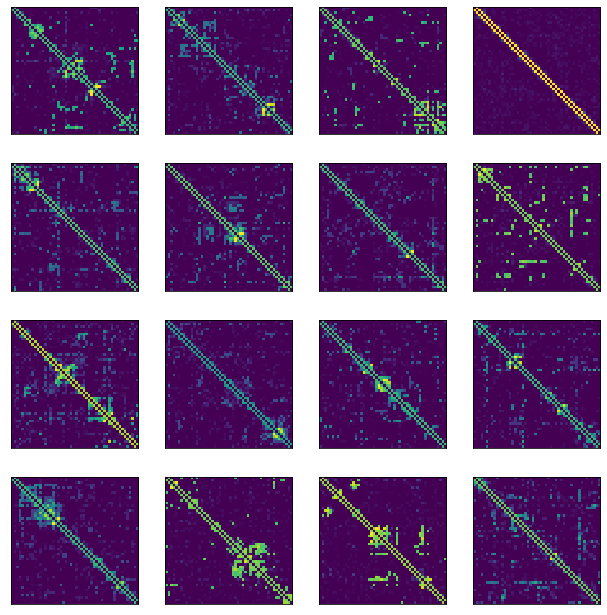

In [9]:
display_dictionary(W = W_true,
                   save_name = save_folder + ntwk_nonumber + "_Dictionary_True",
                   figsize = [10,10])

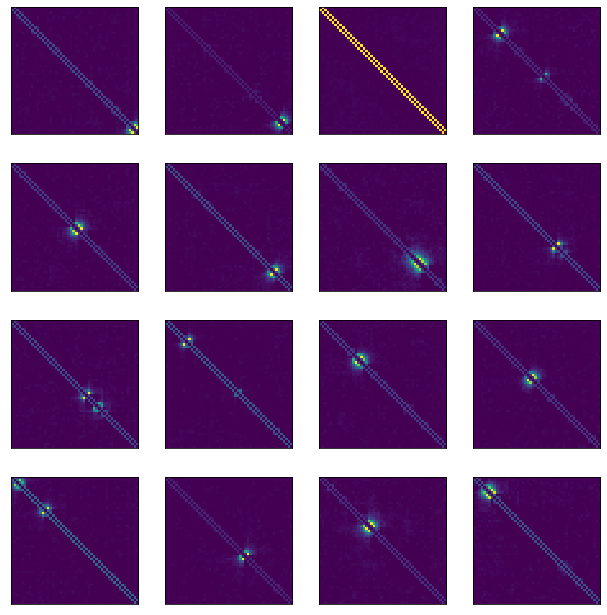

In [10]:
display_dictionary(W = W_false,
                   save_name = save_folder + ntwk_nonumber + "_Dictionary_False",
                   figsize = [10,10])

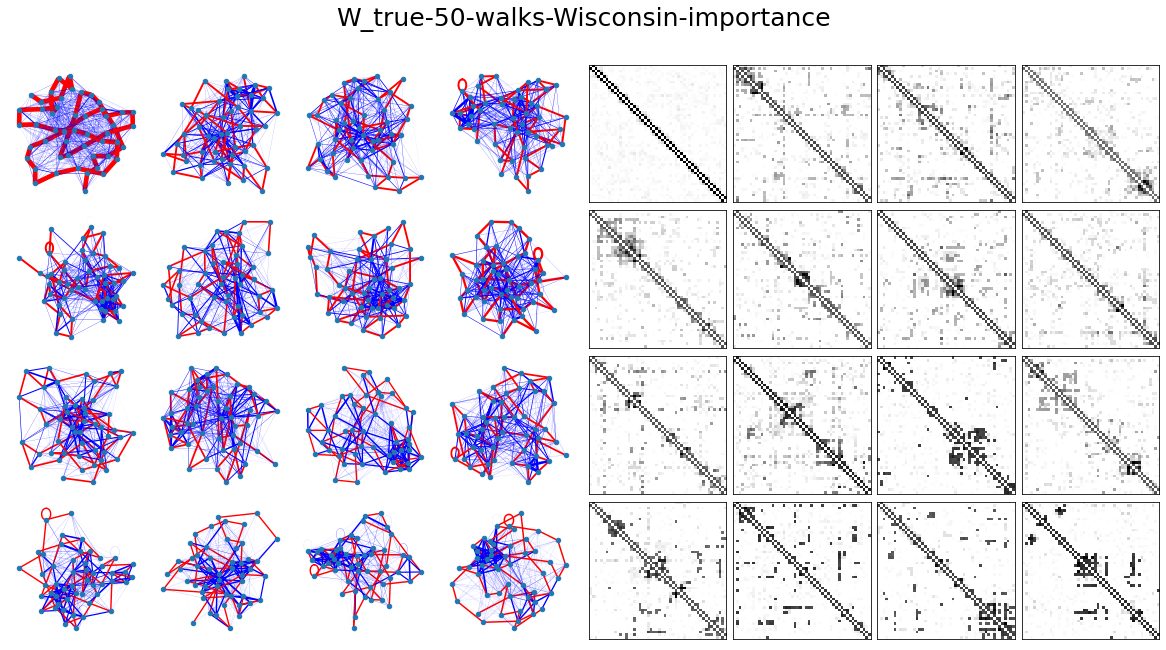

In [11]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_True",
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

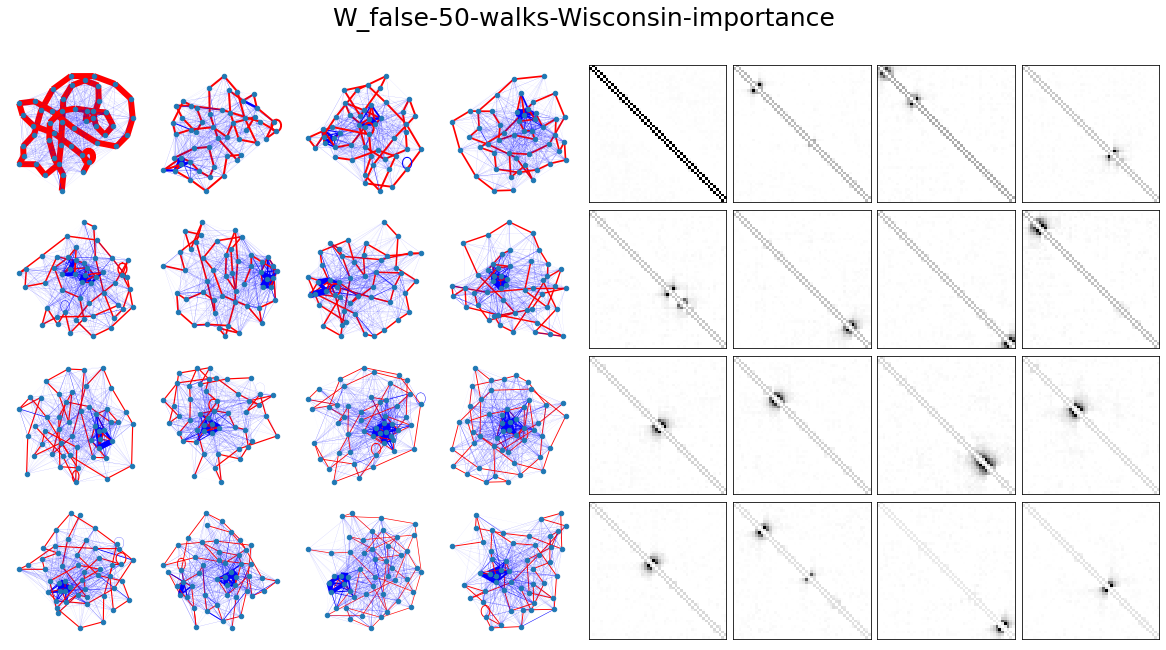

In [12]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_False",
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)